### Coding with Qiskit Episode 5

# Quantum Teleportation

#### Written by Abraham Asfaw, IBM TJ Watson Research Center

In this episode of Coding with Qiskit, we learned about quantum teleportation. Briefly, quantum teleportation allows us to transfer a quantum state from one qubit to another. This might seem fundamentally impossible due to the [no-cloning theorem](https://en.wikipedia.org/wiki/No-cloning_theorem), but the reason it works is because it uses entanglement as a resource. Using the teleportation protocol, quantum information is destroyed in one place, and an exact copy is recreated in another place.

The teleportation protocol was [described by Charles Bennett and co-workers in March 1993](#1), about a decade after the [no-cloning theorem was reported in October 1982](#2).

**Link to Episode 5:** https://www.youtube.com/watch?v=tBnWG_95F9c

In [1]:
from IPython.display import IFrame
IFrame(src="http://www.youtube.com/embed/tBnWG_95F9c", width=1920/2, height=1080/2)

# Building the circuit for quantum teleportation

Let's say we are trying to teleport the quantum state $\vert\psi\rangle$ from Alice to Bob. The teleportation protocol can be summarized as follows:

1. Alice and Bob first create an entangled Bell pair between their two qubits. They do this by using the process described in the [Hello World video](https://www.youtube.com/watch?v=RrUTwq5jKM4) by applying a Hadamard and CX gate. 

2. Next, Alice applies a series of operations between the qubit with state $\vert\psi\rangle$ and her half of the Bell pair.

3. Finally, Alice measures both qubits (the one that initially contained $\vert\psi\rangle$ and the other that contained her half of the Bell pair), and reports these results to Bob.

4. Depending on what Alice says, Bob applies a couple of gates to his half of the Bell pair.

5. And voila! The state $\vert\psi\rangle$ has teleported to Bob's qubit.

In the version that we are building here, Bob will apply his gates conditioned on Alice's qubits, instead of the classical outcomes of the measurements that Alice did. There is a subtle difference between these two methods. While the first method (using Alice's qubits after measurement as the controls of Bob's gates) is easy to implement, the second method (using the classical results of Alice's measurement as controls of Bob's gates) allows quantum teleportation over long distances.

In [2]:
from qiskit import *

In [3]:
circuit = QuantumCircuit(3,3)
# QUBIT ORDERING
# q0 = State |psi> that we want to teleport
# q1 = Alice's half of the Bell pair
# q2 = Bob's half of the Bell pair, the destination of the teleportation

# ========================
# Step 0: Create the state to be teleported in qubit 0
circuit.x(0) # qubit 0 is now in state |1>, and this is the state that we want to teleport

circuit.barrier() # just a visual aid

# ========================
# Step 1: create an entangled Bell pair between Alice and Bob (qubits 1 and 2)
circuit.h(1)
circuit.cx(1,2)

circuit.barrier() # just a visual aid

# ========================
# Step 2: Alice applies a series of operations 
# between the state to teleport (qubit 0) and her half of the Bell pair (qubit 1)
circuit.cx(0,1)
circuit.h(0)

circuit.barrier() # just a visual aid

# ========================
# Step 3: Alice measures both qubits 0 and 1
circuit.measure([0, 1], [0, 1]) # results stored in classical bits 0 and 1, respectively

circuit.barrier() # just a visual aid

# ========================
# Step 4: Now that Alice has measured the two qubits, their states have collapsed to 0 and 1. 
# Bob can do operations conditioned on these qubits to his half of the Bell pair
# Note that while we're conditioning Bob's operation on the collapsed qubits 0 and 1, we can
# do teleportation over long distances by transmitting the classical information in classical bits 0 and 1
circuit.cx(1, 2)
circuit.cz(0, 2)

# Step 5: Done! Measure Bob's qubit to find out what state it is in
circuit.measure([2], [2])

As always, let's draw the circuit before simulating to make sure it's doing what we want

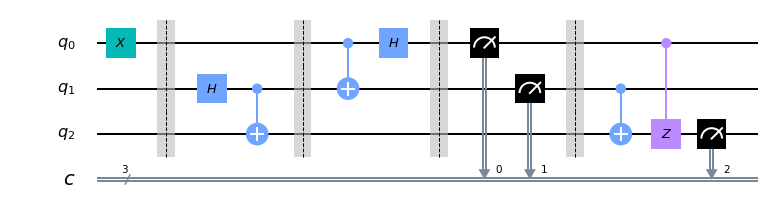

In [4]:
%matplotlib inline
circuit.draw(output='mpl')

# Running the quantum teleportation circuit

And finally, let's simulate the circuit on Aer's `qasm_simulator`

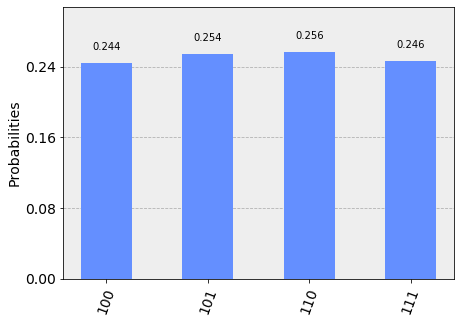

In [5]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1024).result()
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))

Note that the results above are ordered as $c_2c_1c_0$, with the bottom-most bit being $c_2$, which was the result of measuring the state in qubit 2. As you can see, the result is always $c_2 = 1$ since we teleported the state $\vert1\rangle$ to qubit 2.

# Bonus: creating the teleportation circuit using subcircuits

In this section, we will build up the teleportation circuit using subcircuits. This allows us to initialize different instances of the state to be teleported, as you will see below. 

Note the small change in the measurement of qubit 2 -- we are measuring along the Hadamard basis, instead of along the z axis. This is achieved by the use of a Hadamard gate before the measurement.

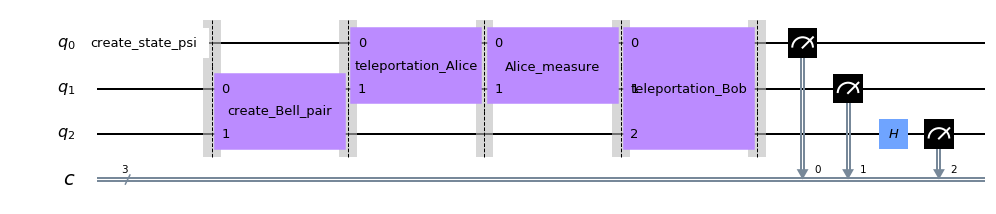

In [6]:
def create_state_psi(theta):
    # Create a state along the x axis on the x-y plane and then rotate it by angle theta around the z-axis
    # theta = 0 => state is exactly along x
    # theta = pi/2 => state is exactly along y
    create_circuit = QuantumCircuit(1, name='create_state_psi')
    create_circuit.h(0)
    create_circuit.rz(theta, 0)
    return create_circuit

def create_Bell_pair():
    create_Bell_circuit = QuantumCircuit(2, name='create_Bell_pair')
    create_Bell_circuit.h(0)
    create_Bell_circuit.cx(0,1)
    return create_Bell_circuit

def teleportation_Alice():
    teleportation_Alice_circuit = QuantumCircuit(2, name='teleportation_Alice')
    teleportation_Alice_circuit.cx(0,1)
    teleportation_Alice_circuit.h(0)
    return teleportation_Alice_circuit

def Alice_measure():
    Alice_measure_circuit = QuantumCircuit(2, 2, name='Alice_measure')
    Alice_measure_circuit.measure([0,1], [0,1])
    return Alice_measure_circuit

def teleportation_Bob():
    teleportation_Bob_circuit = QuantumCircuit(3, name='teleportation_Bob')
    teleportation_Bob_circuit.cx(1,2)
    teleportation_Bob_circuit.cz(0,2)
    return teleportation_Bob_circuit

def build_circuit(theta):
    circuit = QuantumCircuit(3, 3)
    # Step 0: create the state to teleport
    circuit.append(create_state_psi(theta).to_instruction(), [0])
    circuit.barrier()
    # Step 1: create the Bell pair between Alice and Bob's qubits
    circuit.append(create_Bell_pair().to_instruction(), [1,2])
    circuit.barrier()
    # Step 2: Alice applies a series of operations
    circuit.append(teleportation_Alice().to_instruction(), [0,1])
    circuit.barrier()
    # Step 3: Alice measures her two qubits
    circuit.append(Alice_measure().to_instruction(), [0,1], [0,1])
    circuit.barrier()
    # Step 4: Bob applies operations to his qubit depending on Alice's measurement outcomes
    circuit.append(teleportation_Bob().to_instruction(), [0,1,2])
    circuit.barrier()
    # Step 5: Done. Now measure Bob's qubit to be sure that teleportation was successful
    circuit.h(2) # note that the Hadamard gate here ensures that we measure in the Hadamard basis instead of z basis
    circuit.measure([0,1,2], [0,1,2])
    return circuit

circuit = build_circuit(0.01)
circuit.draw(output='mpl')

In order to expand the circuit above, we can write

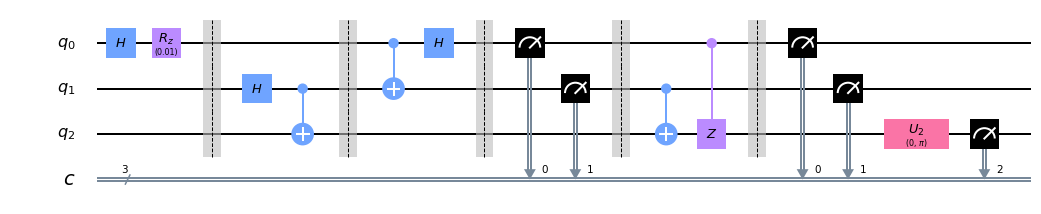

In [7]:
circuit.decompose().draw(output='mpl')

In [8]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1024).result()
counts = result.get_counts(circuit)
print(counts)
num_c2_zero = sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '0')

{'011': 278, '000': 231, '001': 251, '010': 264}


## Now, let's make a loop that iterates over several initial angles $\theta$

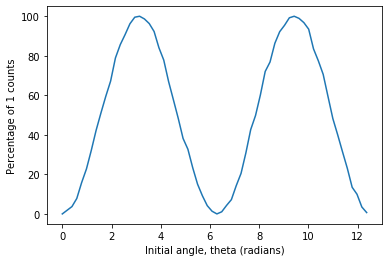

In [9]:
import numpy as np
thetas = np.arange(0, 4*np.pi, np.pi/16)

simulator = Aer.get_backend('qasm_simulator')

percent_ones = []

for theta in thetas:
    circuit = build_circuit(theta)
    result = execute(circuit, backend=simulator, shots=1024).result()
    counts = result.get_counts(circuit)
    num_c2_ones = sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '1')
    percent_ones.append(num_c2_ones*100./1024)
    
import matplotlib.pyplot as plotter
plotter.plot(thetas, percent_ones)
plotter.xlabel('Initial angle, theta (radians)')
plotter.ylabel('Percentage of 1 counts')
plotter.show()

As you can see, the measurement results show a sinusoidal periodicity. Since we are measuring along the Hadamard basis, and we begin with a state that is entirely along the $x$-axis and changes phase on the $x$-$y$ plane, we are able to follow the change in phase with our measurement counts.

# References

#### Journal Papers

1. Charles Bennett et al., 
Teleporting an Unknown Quantum State via Dual Classical and Einstein-Podolsky-Rosen Channels. 
Phys. Rev. Lett. **70**, 1895 (1993). <a id='1'>https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.70.1895</a>


2. W. K. Wootters & W. H. Zurek, 
A single quantum cannot be cloned. 
Nature **299**, 802 (1982). <a id='2'>https://www.nature.com/articles/299802a0</a>

#### Tutorials
For detailed information about Qiskit, check out the tutorials in the Github repository:

https://github.com/Qiskit/qiskit-iqx-tutorials

For a pedagogical presentation of the mathematics behind the quantum teleportation circuit, check out our open-source `Learn Quantum Computation using Qiskit` textbook:

https://community.qiskit.org/textbook/

# Version

It's good to note the Qiskit version that was used in your work. One way to do this is print the version at the bottom of the Jupyter notebook using

In [10]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.9.0',
 'qiskit-ignis': '0.2.0',
 'qiskit-aqua': '0.6.0',
 'qiskit': '0.12.0',
 'qiskit-aer': '0.3.0',
 'qiskit-ibmq-provider': '0.3.2'}

In [11]:
import qiskit.tools.jupyter
%qiskit_copyright